In [1]:
# menghubungkan colab dengan google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# memanggil data set lewat gdrive
path = "/content/gdrive/MyDrive/MachineLearning/praktikum04/"

In [3]:
from pathlib import Path
base = Path('../')
p04 = base / 'praktikum04'
for sub in ['data','model','reports','notebooks']:
    (p04 / sub).mkdir(parents=True, exist_ok=True)
print('Struktur folder siap di:', p04.resolve())

Struktur folder siap di: /praktikum04


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

In [5]:
df = pd.read_csv(path + '/data/calonpembelimobil.csv')

In [6]:
df.info()
print('\nMissing values per kolom:')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ID              1000 non-null   int64
 1   Usia            1000 non-null   int64
 2   Status          1000 non-null   int64
 3   Kelamin         1000 non-null   int64
 4   Memiliki_Mobil  1000 non-null   int64
 5   Penghasilan     1000 non-null   int64
 6   Beli_Mobil      1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB

Missing values per kolom:
ID                0
Usia              0
Status            0
Kelamin           0
Memiliki_Mobil    0
Penghasilan       0
Beli_Mobil        0
dtype: int64


In [7]:
for col in ['Status','Kelamin','Memiliki_Mobil','Beli_Mobil']:
    print(f'\nDistribusi {col}:')
    print(df[col].value_counts().sort_index())


Distribusi Status:
Status
0    240
1    262
2    287
3    211
Name: count, dtype: int64

Distribusi Kelamin:
Kelamin
0    519
1    481
Name: count, dtype: int64

Distribusi Memiliki_Mobil:
Memiliki_Mobil
0    338
1    379
2    277
3      5
4      1
Name: count, dtype: int64

Distribusi Beli_Mobil:
Beli_Mobil
0    367
1    633
Name: count, dtype: int64


In [8]:
feature_cols = ['Usia','Status','Kelamin','Memiliki_Mobil','Penghasilan']
target_col = 'Beli_Mobil'
X = df[feature_cols]
y = df[target_col]
X.shape, y.shape

((1000, 5), (1000,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape

((800, 5), (200, 5))

In [10]:
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), feature_cols)],
    remainder='drop'
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced', random_state=42))
])

model.fit(X_train, y_train)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Usia', 'Status', 'Kelamin',
                                                   'Memiliki_Mobil',
                                                   'Penghasilan'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [11]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print('Accuracy :', round(accuracy_score(y_test, y_pred), 4))
print('Precision:', round(precision_score(y_test, y_pred), 4))
print('Recall   :', round(recall_score(y_test, y_pred), 4))
print('F1-score :', round(f1_score(y_test, y_pred), 4))
print('ROC-AUC  :', round(roc_auc_score(y_test, y_prob), 4))

Accuracy : 0.93
Precision: 0.9829
Recall   : 0.9055
F1-score : 0.9426
ROC-AUC  : 0.9768


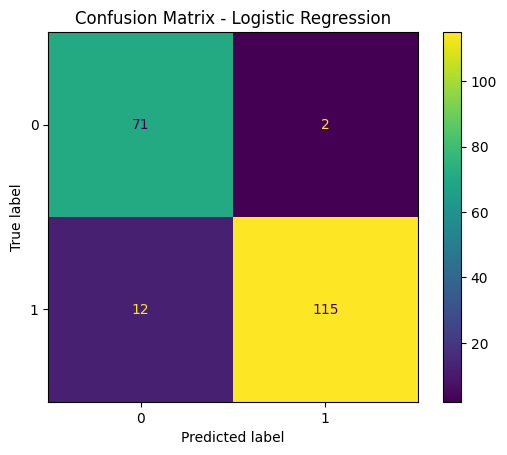

In [12]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot()
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

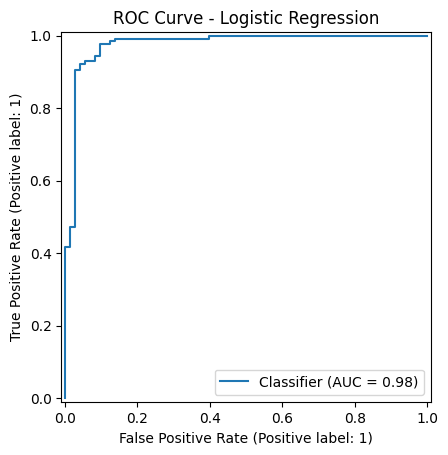

In [13]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title('ROC Curve - Logistic Regression')
plt.show()

In [14]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8554    0.9726    0.9103        73
           1     0.9829    0.9055    0.9426       127

    accuracy                         0.9300       200
   macro avg     0.9192    0.9391    0.9264       200
weighted avg     0.9364    0.9300    0.9308       200



In [15]:
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print('Fold scores:', np.round(scores, 4))
print('Rata-rata akurasi:', round(scores.mean(), 4), '| Std:', round(scores.std(), 4))

Fold scores: [0.78  0.925 0.955 0.945 0.94 ]
Rata-rata akurasi: 0.909 | Std: 0.0652


In [16]:
log_reg = model.named_steps['classifier']
coef_s = pd.Series(log_reg.coef_[0], index=feature_cols, name='Koef (log-odds)')
odds = np.exp(coef_s)
interpretasi = pd.DataFrame({'Fitur': coef_s.index, 'Koefisien (log-odds)': np.round(coef_s.values,4), 'Odds Ratio (e^coef)': np.round(odds.values,4)})
interpretasi.sort_values('Odds Ratio (e^coef)', ascending=False).reset_index(drop=True)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Penghasilan,4.5683,96.3833
1,Memiliki_Mobil,0.0790,1.0822
2,Usia,-0.0451,0.9559
3,Status,-0.1321,0.8763
4,Kelamin,-0.5969,0.5505


In [17]:
import os
from sklearn.linear_model import LinearRegression
import joblib

# Pastikan folder models/ ada
os.makedirs("/content/gdrive/MyDrive/MachineLearning/praktikum04/model", exist_ok=True)

model_path = "/content/gdrive/MyDrive/MachineLearning/praktikum04/model/model_logreg_mobil.pkl"
joblib.dump(model, model_path)

['/content/gdrive/MyDrive/MachineLearning/praktikum04/model/model_logreg_mobil.pkl']

In [18]:
data_baru = pd.DataFrame({
    'Usia':[28,47,35],
    'Status':[1,2,2],
    'Kelamin':[0,1,1],
    'Memiliki_Mobil':[0,1,0],
    'Penghasilan':[180,120,260]
})
prob_baru = model.predict_proba(data_baru)[:,1]
pred_baru = model.predict(data_baru)

hasil = data_baru.copy()
hasil['Prob_Beli'] = np.round(prob_baru, 4)
hasil['Pred_Beli_Mobil'] = pred_baru
hasil

,Usia,Status,Kelamin,Memiliki_Mobil,Penghasilan,Prob_Beli,Pred_Beli_Mobil
0,28,1,0,0,180,0.1331,0
1,47,2,1,1,120,0.0023,0
2,35,2,1,0,260,0.6559,1
